In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# read the dataset
file_path = '/Users/usermacbook/Documents/E-Waste Datasets/Electrical and Electronic Equipment Placed on the Uk Market.xlsx'
def date_parser(year):
    return pd.to_datetime(str(year), format='%Y')
try:
    df = pd.read_excel(file_path,parse_dates=['Date'], index_col='Date')
    print(df.head())
except Exception as e:
    print("Error:", e)

                 Total
Date                  
2008-01-01  1743505.58
2009-01-01  1546565.31
2010-01-01  1534575.95
2011-01-01  1502748.97
2012-01-01  1426174.93


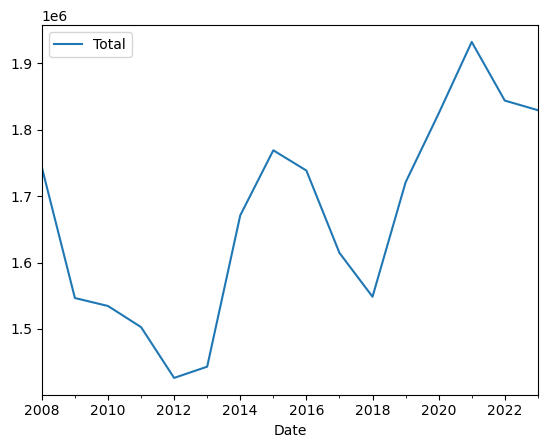

In [36]:
# visulize the data frame
df.plot()
plt.show()

<Axes: xlabel='Date'>

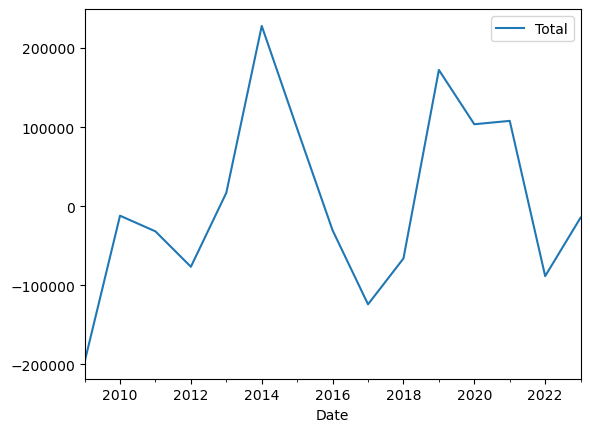

In [50]:
# differentiate to reduce stationarity
df_train_diff = df.diff().dropna()
df_train_diff.plot()

In [51]:
# check for stationarity
adfest = adfuller(df_train_diff)

print('p value of adfuller test is', adfest[1])

p value of adfuller test is 0.2513158433601992


In [37]:
import statsmodels.api as sm

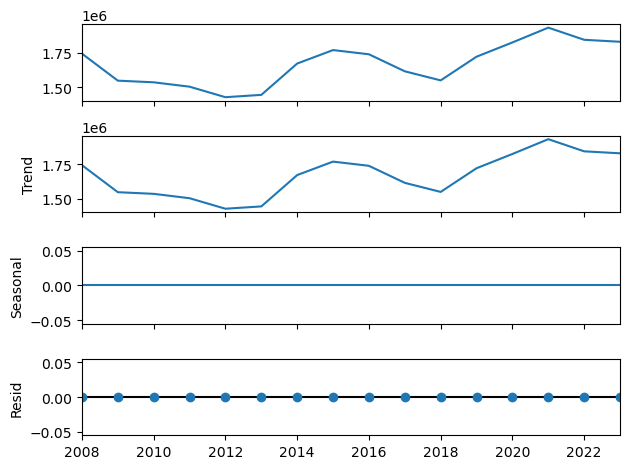

In [38]:
# decompose data to check for seasonality and trend
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [39]:
from statsmodels.tsa.stattools import adfuller

In [40]:
# check the pvalue of dateset to determine stationarity
adfest = adfuller(df['Total'])

print('p value of adfuller test is', adfest[1])

p value of adfuller test is 0.9977889983601226


In [41]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [116]:
# split datasets into training and test sets
from statsmodels.tsa.arima.model import ARIMA
train = df[:12]
test = df[12:]
trainer = df_train_diff[:10]
tester = df_train_diff[:10]

In [117]:
# use itertools to determine the range
import itertools

p = range(0,8)
q = range(0,8)
d = range(0,2)

pdq_combination = list(itertools.product(p,d,q))

len(pdq_combination)

128

In [118]:
rmse=[]
order1=[]

In [119]:
# identify the pdq using the loop method
from sklearn.metrics import mean_squared_error
for pdq in pdq_combination:
    try:
        model= ARIMA(train,order = pdq).fit()
        pred = model.predict(start=len(train), end=(len(df)-1))
        error = np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)

    except Exception as e:
        print(f"Error encountered for {pdq}: {e}")
        continue

Error encountered for (7, 1, 0): LU decomposition error.


In [120]:
results = pd.DataFrame(index=order1,data=rmse,columns=['RMSE'])

In [121]:
# append results to csv file
results.to_csv('ARIMA_result_produced.csv')

In [215]:
# train model for testing
model = ARIMA(train, order=(2,1,2))
model = model.fit()
print(model.summary())
# model = ARIMA(train, order=(6,1,4))
# model = model.fit()
# print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   12
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -142.187
Date:                Fri, 26 Apr 2024   AIC                            294.373
Time:                        20:14:59   BIC                            296.363
Sample:                    01-01-2008   HQIC                           293.119
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1897      0.069     17.317      0.000       1.055       1.324
ar.L2         -0.9429      0.025    -38.084      0.000      -0.991      -0.894
ma.L1         -1.2862      0.303     -4.247      0.0

In [216]:
# make test predictions
start = len(train)
end = len(df)-1
pred = model.predict(start=start, end=end,)
print(pred)

2020-01-01    1.810664e+06
2021-01-01    1.889099e+06
2022-01-01    1.897762e+06
2023-01-01    1.834115e+06
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [217]:
# find rmse
from sklearn.metrics import mean_squared_error,mean_absolute_error

error = np.sqrt(mean_squared_error(test,pred))
error

35271.45830796194

In [218]:
rmse = error
mae = mean_absolute_error(test, pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 35271.45830796194
Root Mean Squared Error (RMSE): 187.80697087158916
Mean Absolute Error (MAE): 28849.784763998643


In [219]:
mean_actual_values = df.mean()
print(mean_actual_values)

Total    1.668163e+06
dtype: float64


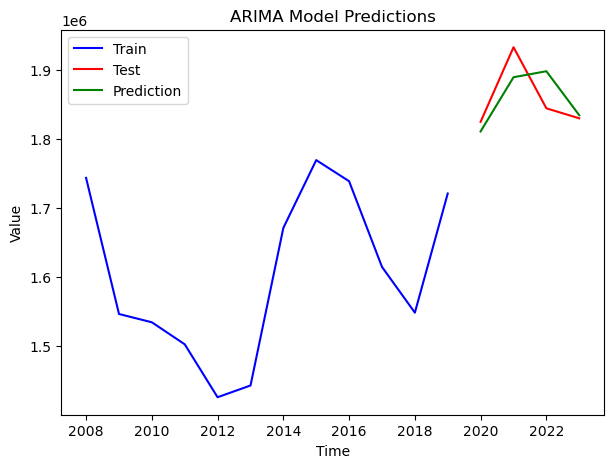

In [226]:
# Plot all data on the same graph
plt.figure(figsize=(7, 5))

# Plot training data
plt.plot(train.index, train.values, label='Train', color='blue')

# Plot testing data
plt.plot(test.index, test.values, label='Test', color='red')

# Plot predictions
plt.plot(pred.index, pred.values, label='Prediction', color='green')


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Predictions')

plt.legend()

In [222]:
# make final prediction
final_model = ARIMA(df,order=(6,1,4)).fit()
prediction = final_model.predict(len(df),len(df)+6)

In [223]:
print(prediction)

2024-01-01    1.852548e+06
2025-01-01    1.948268e+06
2026-01-01    2.017768e+06
2027-01-01    2.011204e+06
2028-01-01    1.962698e+06
2029-01-01    1.953826e+06
2030-01-01    2.005286e+06
Freq: AS-JAN, Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

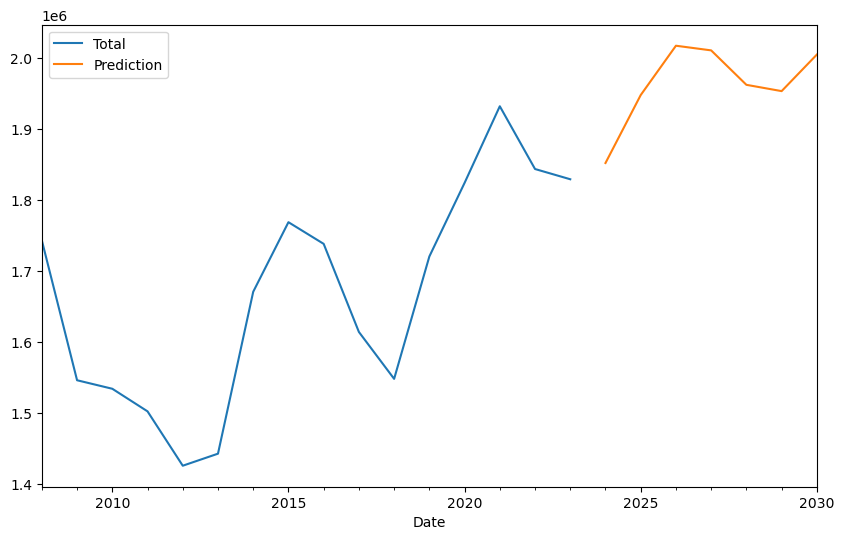

In [193]:
# plot prediction
df.plot(legend= True, label='Train', figsize=(10,6))
prediction.plot(legend= True, label='Prediction',)

In [224]:
# evaluate using the r2_score
from sklearn.metrics import r2_score

r2 = r2_score(test,pred)

print(f'R-squared score: {r2}')

R-squared score: 0.35068992688345024


In [228]:
# append results to a file
file_path = 'arima_produced_predictions.csv'

prediction.to_frame().to_csv(file_path, header=['Predictions'])